# Проект для «Викишоп»

Интернет-магазин запускает новый сервис - пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. Клиенты предлагают свои правки и комментируют изменения других. Интернет-магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

**Цель проекта** - обучить модель классифицировать комментарии на позитивные и негативные. 

Данные находятся в файле toxic_comments.csv. Столбец *'text'* содержит текст комментариев, а *'toxic'* — целевой признак

# Подготовка

Загрузим необходимые библиотеки:

In [1]:
import pandas as pd

import re, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from catboost import CatBoostClassifier

import  matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

Загрузим и прочитаем файл:

In [2]:
data = pd.read_csv('toxic_comments.csv')

In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [5]:
data.iloc[[100, 1000, 10000]]

,text,toxic
100,"However, the Moonlite edit noted by golden dap...",0
1000,Rex Mundi \n\nI've created a stub on Rex Mundi...,0
10000,Hi RedRose and apologies for delay. Here is a ...,0


У нас два столбца с объектным и целочисленным типам данных. Пропусков нет.

Посмотрим на соотношения "позитивных" и "негативных" комментариев:

0    143346
1     16225
Name: toxic, dtype: int64 



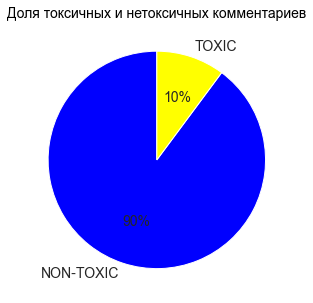

In [6]:
# toxic and non-toxic comments

ratio = data['toxic'].value_counts()
print(ratio, '\n')

plt.figure(figsize=(5,5))
plt.title('Доля токсичных и нетоксичных комментариев', fontsize=14, color='black')

labels=['NON-TOXIC', 'TOXIC']
ratio.plot(kind='pie', startangle=90, textprops={'fontsize': 14},
           labels=labels, autopct = '%0.0f%%', colors = ['blue', 'yellow'])
plt.ylabel('');

10% комментариев токсичные и 90% нет. Классы несбалансированы - учтем это при разбиение датасета на выборки и используем параметр stratify=y.

Приступим к подготовке данных.

Очистим и лемматизируем текст:

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def prepocessed(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ''.join(lemmatizer.lemmatize(text))
    
    final_sent = []
    for i in text.split():
        if i.strip() not in stop_words:
            final_sent.append(i.strip())
    return ' '.join(final_sent)
    

In [8]:
data['lemm_text'] = data['text'].apply(prepocessed)

In [9]:
data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww matches background colour seemingly stuck ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestions improvement wondered sec...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


# Вывод

Мы произвели чтение и загрузку данных. Подготовили данные для обучения: лемматизировали и очистили комментарии, добавили столбец обработанного текста в таблицу.

Можем приступать к обучению.

# Обучение

# Подготовка к обучению

Подготовим данные для обучения. Разобьем датасет на три выборки: трейн, валид и тест. 

Сначала обучим модель на трейне и сделаем предсказание на валиде. Выбрав лучшую модель, проверим качество предсказаний на тесте.

В исследовании будем использовать 3 алгоритма:

1. LogisticRegression()
2. SGDClassifier()
3. CatBoostClassifier()

Сравним, какая из моделей покажет более высокое качество предсказаний.

Выделим признак и целевой признак:

In [10]:
X = data['lemm_text']  
y = data['toxic']

Разобьем датасет на обучающую, валидационную и тестовую выборку:

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.4, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=0)

Чтобы тестирование было честным и модель не учитывала частоты слов из валидационной/тестовой выборки, функцию fit() запустим только на обучающей выборке; конвертируем все выборки:

In [12]:
tf_idf = TfidfVectorizer() 

X_train = tf_idf.fit_transform(X_train)
X_valid = tf_idf.transform(X_valid)
X_test = tf_idf.transform(X_test)

print('Размер обучающей выборки: ', X_train.shape)
print('Размер валидационой выборки: ', X_valid.shape)
print('Размер тестовой выборки: ', X_test.shape)

Размер обучающей выборки:  (95742, 138949)
Размер валидационой выборки:  (31914, 138949)
Размер тестовой выборки:  (31915, 138949)


# Обучение моделей

**LogisticRegression()**

In [13]:
%%time 

model_LR = LogisticRegression(C=25, class_weight='balanced', n_jobs=-1, random_state=0)
model_LR.fit(X_train, y_train)
preds_LR = model_LR.predict(X_valid)
recall_LR = recall_score(y_valid, preds_LR)
precision_LR = precision_score(y_valid, preds_LR)
f1_LR = f1_score(y_valid, preds_LR)
print('Полнота: ', recall_LR)
print('Точность: ', precision_LR)
print('F1_score: ', f1_LR, '\n')

Полнота:  0.7897035881435257
Точность:  0.7441928844457513
F1_score:  0.766273085074175 

Wall time: 10.8 s


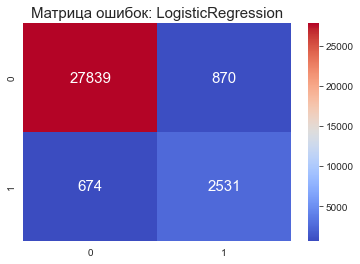

In [14]:
sns.heatmap(confusion_matrix(y_valid, preds_LR), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: LogisticRegression', size=15)
plt.show()

F1-мера составила 0.77. Модель с достаточно высоким уровнем точности выявляет токсичные комментарии.

**SGDClassifier()**

In [15]:
model_SGD = SGDClassifier(alpha=1e-6, class_weight='balanced', n_jobs=-1, random_state=0)
model_SGD.fit(X_train, y_train)
preds_SGD = model_SGD.predict(X_valid)
recall_SGD = recall_score(y_valid, preds_SGD)
precision_SGD = precision_score(y_valid, preds_SGD)
f1_SGD = f1_score(y_valid, preds_SGD)
print('Полнота: ', recall_SGD)
print('Точность: ', precision_SGD)
print('F1_score: ', f1_SGD)

Полнота:  0.7906396255850234
Точность:  0.7017446690667405
F1_score:  0.7435446009389672


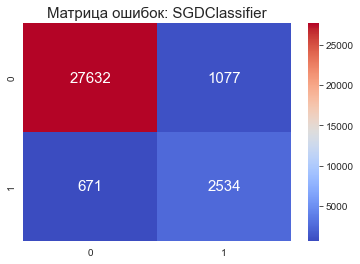

In [16]:
sns.heatmap(confusion_matrix(y_valid, preds_SGD), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: SGDClassifier', size=15)
plt.show()

В сравнении с Логистической регрессий, точность SGDClassifier немного выше, но вот ложноотрицательных ошибок заметно больше. 

**CatBoostClassifier()**

In [17]:
model_Cat = CatBoostClassifier(learning_rate=0.9, loss_function='Logloss', iterations=200, 
                               depth=4, random_state=0, verbose=False)
model_Cat.fit(X_train, y_train)
preds_Cat = model_Cat.predict(X_valid)
recall_Cat = recall_score(y_valid, preds_Cat)
precision_Cat = precision_score(y_valid, preds_Cat)
f1_Cat = f1_score(y_valid, preds_Cat)
print('Полнота: ', recall_Cat)
print('Точность: ', precision_Cat)
print('F1_score: ', f1_Cat, '\n')

Полнота:  0.6667706708268331
Точность:  0.8561698717948718
F1_score:  0.7496930363094194 



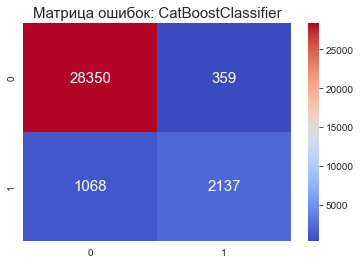

In [18]:
sns.heatmap(confusion_matrix(y_valid, preds_Cat), fmt='3.0f', annot=True, cmap='coolwarm', annot_kws={"size":15})
plt.title('Матрица ошибок: CatBoostClassifier', size=15)
plt.show()

Catboost справляется с поставленной задачей не лучшим образом.

Объединим результат в одну таблицу:

In [19]:
score_table = pd.DataFrame(data=[[f1_LR, recall_LR, precision_LR], 
                                 [f1_SGD, recall_SGD, precision_SGD], 
                                 [f1_Cat, recall_Cat, precision_Cat]],
                       columns = ['F1_score', 'Recall', 'Precision'], 
                       index = ['LogisticRegression', 'SGDClassifier', 'CatBosstClassifier']).sort_values(by='F1_score', ascending=False)
score_table

,F1_score,Recall,Precision
LogisticRegression,0.766273,0.789704,0.744193
CatBosstClassifier,0.749693,0.666771,0.856170
SGDClassifier,0.743545,0.790640,0.701745


Модели демонстрируют близкие по значению результаты, но наша цель - выявить токсичный комментарий. И Логистическая регрессия справляется с этой задачей несколько лучше остальных. Именно данную модель будем использовать для тестирования.

# Тестирование модели

Проверим модель LogisticRegression с установленными гиперпараметрами на тестовой выборке:

In [20]:
%%time 

preds_test_LR = model_LR.predict(X_test)
recall_test_LR = recall_score(y_test, preds_test_LR)
precision_test_LR = precision_score(y_test, preds_test_LR)
f1_test_LR = f1_score(y_test, preds_test_LR)
print('Полнота: ', recall_test_LR)
print('Точность: ', precision_test_LR)
print('F1_score: ', f1_test_LR, '\n')

Полнота:  0.7887366818873668
Точность:  0.7385974914481186
F1_score:  0.7628441042249375 

Wall time: 50 ms


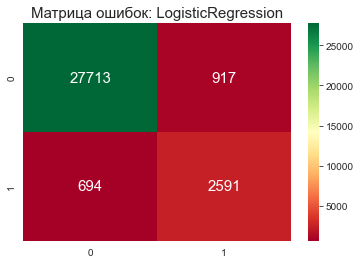

In [21]:
sns.heatmap(confusion_matrix(y_test, preds_test_LR), fmt='3.0f', annot=True, cmap='RdYlGn', annot_kws={"size":15})
plt.title('Матрица ошибок: LogisticRegression', size=15)
plt.show()

Неплохой результат. Число выявленных токсичных отзывов на тестовой выборке даже выше, чем на валидационной. Однако следует отметить больше ошибок при ложноположительных и ложноотрицательных ответах.

# Вывод

Мы подготовили данные для обучения и использовали несколько алгоритмов: Логистическая регрессия, метод Стохастического градиентного спуска и CatBoost. Лучше всего себя показала модель LogisticRegression, с набольшей точностью определившая число токсичных комментариев.

# Общий вывод

В рамках данного проекта: 

1. Данные были загружены, прочитаны и обработаны (лемматизация и очистка текста);
2. Для обучения произведена векторизация текста (создана матрица TF-IDF);
3. Проверены несколько моделей обучения.


В результате с помощью LogisticRegression удалось достичь значения метрики качества F1 = 0.77 на валидацинной выборке и 0.76 на тестовой. В случае определения токсичности комментариев значение точности важнее полноты - но все хорошо в меру.